<a href="https://colab.research.google.com/github/jery5237hent/Deep-Learning/blob/main/HW2_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2021)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    n_hidden_channel = 256

    self.encoder = nn.Sequential(
        # nn.BatchNorm2d(n_channel),
        nn.Conv2d(in_channels = n_channel, out_channels=n_hidden_channel, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(n_hidden_channel),
        nn.ReLU(),
        nn.Conv2d(in_channels = n_hidden_channel, out_channels=n_hidden_channel * 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(n_hidden_channel * 2),
        nn.ReLU(),
        nn.Flatten()
    )
    self.fc1 = nn.Linear(in_features = n_hidden_channel * 2 * 7 * 7, out_features=latent_dims)
    self.fc2 = nn.Linear(in_features = n_hidden_channel * 2 * 7 * 7, out_features=latent_dims)

    self.decoder = nn.Sequential(
        nn.Linear(in_features = latent_dims, out_features=n_hidden_channel * 2 * 7 * 7),
        nn.Unflatten(1, (n_hidden_channel * 2, 7, 7)),
        nn.ConvTranspose2d(in_channels = n_hidden_channel * 2, out_channels=n_hidden_channel, kernel_size=4, stride=2, padding=1),
        # nn.BatchNorm2d(n_hidden_channel),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels = n_hidden_channel, out_channels=n_channel , kernel_size=4, stride=2, padding=1),
        # nn.BatchNorm2d(n_channel),
        nn.Sigmoid()
    )

  def latent(self, x):
    self.mu = self.fc1(x)
    self.ln_var = self.fc2(x)
    std = self.ln_var.mul(0.5).exp_()
    epsilon = torch.randn(*std.size()).to(device)

    return epsilon.mul(std).add_(self.mu)

  def loss(self, beta, initial_img):
    loss = F.binary_cross_entropy(self.z.view(-1, WIDTH * HEIGHT), initial_img.view(-1, WIDTH * HEIGHT), reduction='sum')
    kl = -0.5 * torch.sum(1 + self.ln_var - self.mu.pow(2) - self.ln_var.exp())

    return beta * kl + loss
    
  def forward(self, x):
    dim = x.size(0)
    x = self.encoder(x)
    z = self.latent(x)
    z = self.decoder(z)
    self.z = z.view(dim, n_channel, WIDTH, HEIGHT)

    return self.z

  def interpolation(self, img1, img2):
    model.eval()
    interploation_lambda = np.linspace(0, 1, 11)
    fig, axs = plt.subplots(1, 11, figsize=(15, 12)) 
    img1, img2 = img1.float().unsqueeze(0).to(device), img2.float().unsqueeze(0).to(device)
    
    with torch.no_grad():
      for idx, l in enumerate(interploation_lambda):
        latent = model.encoder(img1)
        latent = model.fc1(latent)

        latent_1 = model.encoder(img2)
        latent_1 = model.fc1(latent_1)

        inter = l * latent + (1 - l) * latent_1
        inter_image = model.decoder(inter)
        inter_image = inter_image.cpu()

        plt.subplot(1, 11, idx + 1)
        plt.imshow(inter_image[0].squeeze(0), cmap='gray')
        plt.title('lambda = ' + str(round(l, 1)))
      plt.savefig('VAE_Q4_interpolation.png')
      plt.show() 

  def sample(self):
    model.eval()

    with torch.no_grad():

      latent = torch.randn(64, latent_dims, device=device)
      prediction = model.decoder(latent).cpu()
      prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
      Image = np.transpose(prediction_grid, (1, 2, 0))
      Image = Image/np.amax(Image)
      Image = np.clip(Image, 0, 1)

      plt.figure(figsize=(10, 8))
      plt.imshow(Image)
      plt.title('Sample from prior:')
      plt.savefig('VAE_Q3_sample.png')
      plt.show()

In [ ]:
f = np.load('TibetanMNIST.npz')
y = f['label']
images = f['image']
X, y = torch.from_numpy(images//128).unsqueeze(1), torch.from_numpy(y)
DATA = TensorDataset(X, y)
n_batch = 64

In [ ]:
train, test = random_split(DATA, [int(0.8*len(DATA)), int(0.2*len(DATA))], generator = torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size = n_batch, shuffle=True)
test_loader = DataLoader(test, batch_size = n_batch, shuffle=True)

In [ ]:
latent_dims = 2
n_epochs = 30
lr = 1e-3
beta = 1
WIDTH = HEIGHT = 28
n_channel = 1

In [ ]:
def VAE_train(beta):
  model = VAE().to(device)
  optimizer = optim.Adam(params = model.parameters(), lr = lr, weight_decay=1e-5)
  model.train()
  loss = []

  for epoch in range(n_epochs):
    epoch_loss = 0
    n = 0
    for batch_img in train_loader:
        optimizer.zero_grad()
        batch_img[0] = batch_img[0].float().to(device)
        prediction = model(batch_img[0])

        batch_loss = model.loss(beta, batch_img[0])

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        n += batch_img[0].shape[0]
    epoch_loss /= n
    loss.append(epoch_loss)

    print(f'Epoch: {epoch+1} / {n_epochs}, loss: {epoch_loss}')
  return model, loss

Epoch: 1 / 30, loss: 347.90885854085286
Epoch: 2 / 30, loss: 268.63609029134113
Epoch: 3 / 30, loss: 272.6185490926107
Epoch: 4 / 30, loss: 255.3613985188802
Epoch: 5 / 30, loss: 249.88326385498047
Epoch: 6 / 30, loss: 248.67633677164713
Epoch: 7 / 30, loss: 243.76583302815754
Epoch: 8 / 30, loss: 244.58268127441406
Epoch: 9 / 30, loss: 240.92519561767577
Epoch: 10 / 30, loss: 240.29941772460938
Epoch: 11 / 30, loss: 236.259001566569
Epoch: 12 / 30, loss: 233.15998799641926
Epoch: 13 / 30, loss: 233.06728759765625
Epoch: 14 / 30, loss: 229.91057556152344
Epoch: 15 / 30, loss: 229.05131184895833
Epoch: 16 / 30, loss: 228.0622119140625
Epoch: 17 / 30, loss: 226.31627003987631
Epoch: 18 / 30, loss: 227.5140380859375
Epoch: 19 / 30, loss: 223.3047738647461
Epoch: 20 / 30, loss: 223.22264556884767
Epoch: 21 / 30, loss: 223.0534295654297
Epoch: 22 / 30, loss: 221.41577545166015
Epoch: 23 / 30, loss: 220.41261189778646
Epoch: 24 / 30, loss: 219.74966522216798
Epoch: 25 / 30, loss: 218.0031434

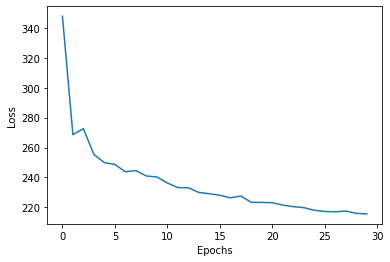

In [ ]:
import matplotlib.pyplot as plt
model, loss = VAE_train(1)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Learning_curve_beta1.png')
plt.show()

In [ ]:
def VAE_test(beta):
  model.eval()

  test_loss = 0
  n = 0
  for batch_img, _ in test_loader:
      with torch.no_grad():
          batch_img = batch_img.float().to(device)
          prediction = model(batch_img)
          loss = model.loss(beta, batch_img)

          test_loss += loss.item()
          n += batch_img.shape[0]
  test_loss /= n
  # test_losses.append(epoch_loss)
  print(f'loss: {test_loss}' )

VAE_test(beta)

loss: 225.41586791992188


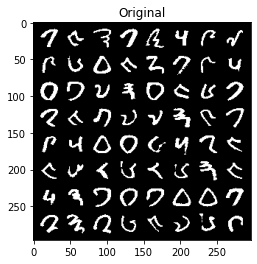

In [ ]:
from torchvision.utils import make_grid

img, label = iter(test_loader).next()
original = make_grid(img[:64], 8, 8).numpy()
plt.imshow(np.transpose(original, (1, 2, 0)))
plt.title('Original')
plt.savefig('Original_Q1_VAE.png')
plt.show()

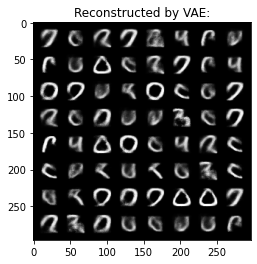

In [ ]:
with torch.no_grad():
  img = img.float().to(device)
  prediction = model(img).cpu()
  original = make_grid(prediction[:64], 8, 8).numpy()
  plt.imshow(np.transpose(original, (1, 2, 0)))
  plt.title('Reconstructed by VAE:')
  plt.savefig('Reconstructed_Q1_VAE.png')
  plt.show()

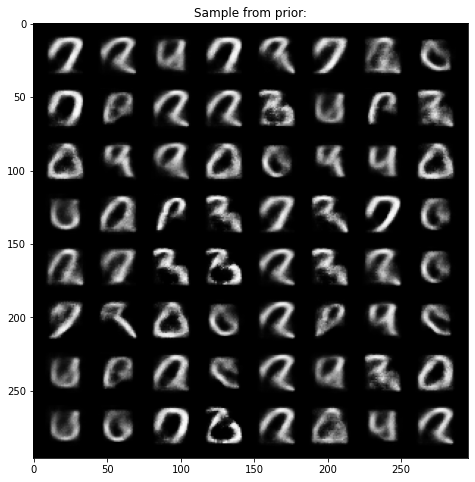

In [ ]:
model.sample()

In [ ]:
def recover(img):
  img = img.numpy()
  Image = np.transpose(img, (1, 2, 0))
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)

  return Image

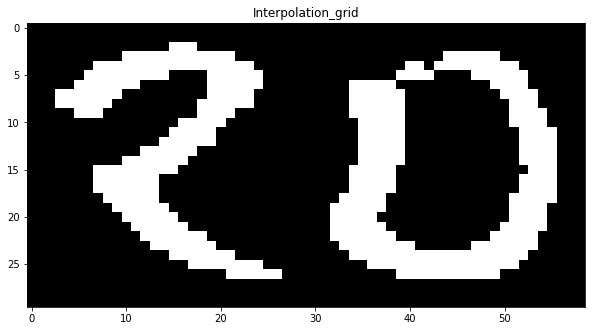

In [ ]:
img = iter(test_loader).next()
interpolation_grid = make_grid(img[0][:2], 2, 1)#.numpy()
# Image = np.transpose(interpolation_grid, (1, 2, 0))
# Image = Image/np.amax(Image)
# Image = np.clip(Image, 0, 1)
Image = recover(interpolation_grid)
plt.figure(figsize=(10, 8))
plt.imshow(Image)
plt.title('Interpolation_grid')
plt.savefig('Interpolation_Q4_VAE.png')
plt.show()

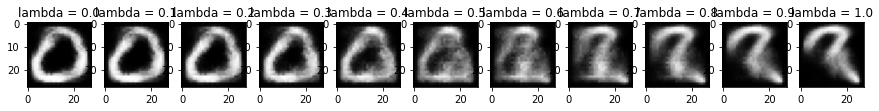

In [ ]:
img1, img2 = img[0][0], img[0][1]
model.interpolation(img1, img2)
# plt.subplots(1, 2)
# plt.subplot(1,2,1)
# plt.imshow(img1.squeeze(0), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(img2.squeeze(0), cmap='gray')

Epoch: 1 / 30, loss: 340.13907135009765
Epoch: 2 / 30, loss: 258.7889442952474
Epoch: 3 / 30, loss: 254.36442504882814
Epoch: 4 / 30, loss: 249.0015938313802
Epoch: 5 / 30, loss: 245.77090291341145
Epoch: 6 / 30, loss: 242.260637105306
Epoch: 7 / 30, loss: 237.58938608805337
Epoch: 8 / 30, loss: 231.8423486328125
Epoch: 9 / 30, loss: 235.58875620524088
Epoch: 10 / 30, loss: 228.90429656982423
Epoch: 11 / 30, loss: 227.51696268717447
Epoch: 12 / 30, loss: 225.3200762939453
Epoch: 13 / 30, loss: 223.52131540934244
Epoch: 14 / 30, loss: 221.8376037597656
Epoch: 15 / 30, loss: 220.57858367919923
Epoch: 16 / 30, loss: 219.40165211995443
Epoch: 17 / 30, loss: 218.81191416422527
Epoch: 18 / 30, loss: 216.23135314941408
Epoch: 19 / 30, loss: 214.42846028645835
Epoch: 20 / 30, loss: 215.15363566080728
Epoch: 21 / 30, loss: 212.27923563639322
Epoch: 22 / 30, loss: 212.36475565592448
Epoch: 23 / 30, loss: 210.9934454345703
Epoch: 24 / 30, loss: 209.61796040852866
Epoch: 25 / 30, loss: 211.1435292

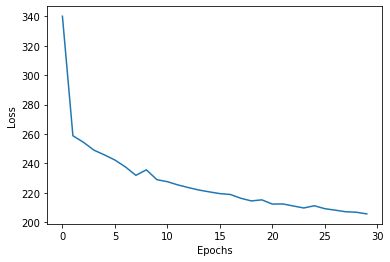

In [ ]:
beta = 0
model, loss = VAE_train(beta)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Learning_curve_beta0.png')
plt.show()

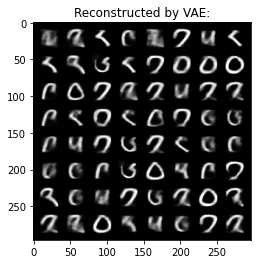

In [ ]:
with torch.no_grad():
  img, label = iter(test_loader).next()
  img = img.float().to(device)
  prediction = model(img).cpu()
  original = make_grid(prediction[:64], 8, 8).numpy()
  plt.imshow(np.transpose(original, (1, 2, 0)))
  plt.title('Reconstructed by VAE:')
  plt.savefig('Reconstructed_Q1_VAE_beta0.png')
  plt.show()

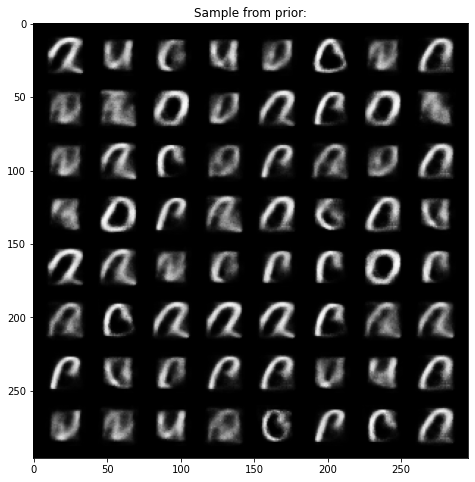

In [ ]:
model.sample()

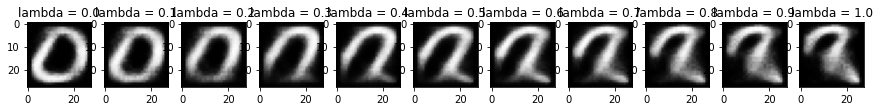

In [ ]:
model.interpolation(img1, img2)

Epoch: 1 / 30, loss: 1592.450581665039
Epoch: 2 / 30, loss: 345.9930432128906
Epoch: 3 / 30, loss: 341.3584114583333
Epoch: 4 / 30, loss: 340.9262890625
Epoch: 5 / 30, loss: 336.55736450195315
Epoch: 6 / 30, loss: 335.73891092936196
Epoch: 7 / 30, loss: 335.22693115234375
Epoch: 8 / 30, loss: 333.85808553059894
Epoch: 9 / 30, loss: 333.0214217122396
Epoch: 10 / 30, loss: 333.0050927734375
Epoch: 11 / 30, loss: 331.61981282552085
Epoch: 12 / 30, loss: 332.05890584309896
Epoch: 13 / 30, loss: 332.9732676188151
Epoch: 14 / 30, loss: 332.0171044921875
Epoch: 15 / 30, loss: 333.25560770670575
Epoch: 16 / 30, loss: 343.1058485921224
Epoch: 17 / 30, loss: 336.6779319254557
Epoch: 18 / 30, loss: 331.55843526204427
Epoch: 19 / 30, loss: 344.16176330566407
Epoch: 20 / 30, loss: 338.45720153808594
Epoch: 21 / 30, loss: 333.00090555826824
Epoch: 22 / 30, loss: 334.71221435546875
Epoch: 23 / 30, loss: 10939.191009318034
Epoch: 24 / 30, loss: 238816.40184244793
Epoch: 25 / 30, loss: 6552390653548909

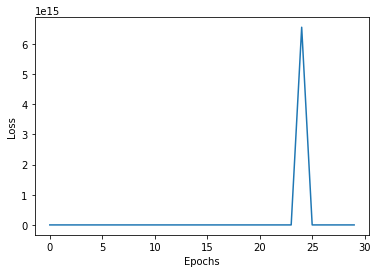

In [ ]:
beta = 100
model, loss = VAE_train(beta)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Learning_curve_beta100.png')
plt.show()

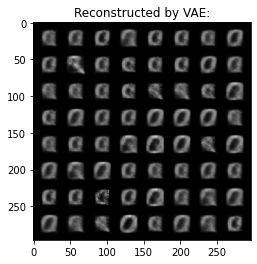

In [ ]:
with torch.no_grad():
  img, label = iter(test_loader).next()
  img = img.float().to(device)
  prediction = model(img).cpu()
  original = make_grid(prediction[:64], 8, 8).numpy()
  plt.imshow(np.transpose(original, (1, 2, 0)))
  plt.title('Reconstructed by VAE:')
  plt.savefig('Reconstructed_Q1_VAE_beta100.png')
  plt.show()

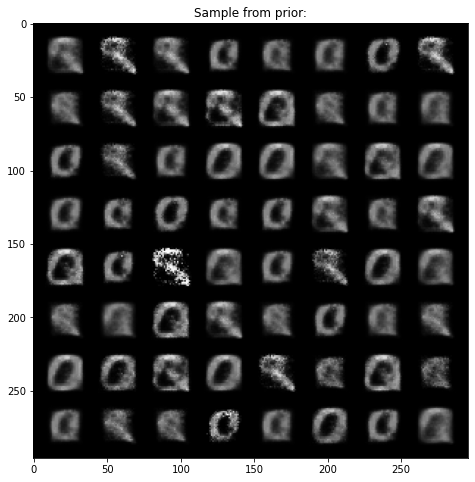

In [ ]:
model.sample()

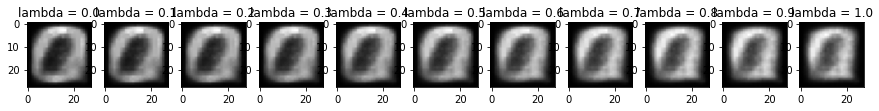

In [ ]:
model.interpolation(img1, img2)